# Triple Pendulum CHAOS!

*This, as well as the underlying pendulum implementation, is based on this post [post](http://jakevdp.github.io/blog/2017/03/08/triple-pendulum-chaos/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is MIT licensed.*

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy.integrate import odeint


# FILE = "experiments/tmp/0-X_pred.npy"
FILE = "pendulum-cache/p-physics-2.npy"
N = 1

data = np.load(FILE)
print(f"Loaded data: {data.shape}")
# Data is of shape (n_timesteps, n_samples, 2*n_links)

Loaded data: (1000, 1000, 4)


## Extracting Positions

The function above returns generalized coordinates, which in this case are the angular position and velocity of each pendulum segment, relative to vertical.
To visualize the pendulum, we need a quick utility to extract *x* and *y* coordinates from these angular coordinates:

In [38]:
selected_data = data[:,8,:]

In [39]:
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

Finally, we can call this function to plot the movement of a pendulum over time:

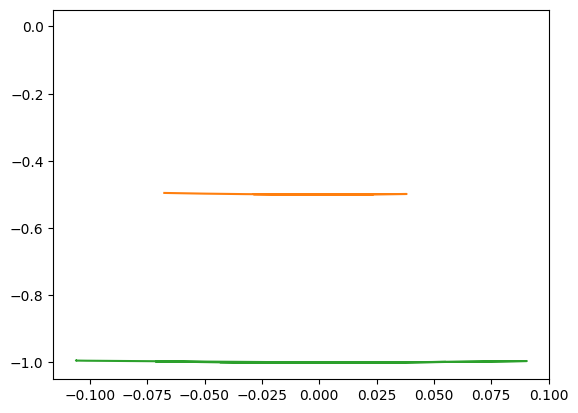

In [40]:
x, y = get_xy_coords(selected_data)
plt.plot(x, y);

And here are the positions of a triple pendulum over time:

In [41]:
from models import pendulum_energy
import torch
energy_func = pendulum_energy.pendulum_energy(N)

In [42]:
from importlib import reload
pendulum_energy = reload(pendulum_energy)
energy_func = pendulum_energy.pendulum_energy(N)

In [43]:
def getEnergyViolations(selected_data):
    """Get energy and violations for each timestep"""
    energy = energy_func(torch.tensor(selected_data)).numpy()
    
    violations = []
    p_e = 999999
    for i, e in enumerate(energy):
        if p_e < e:
            violations.append(i)
        p_e = e

    return energy, violations

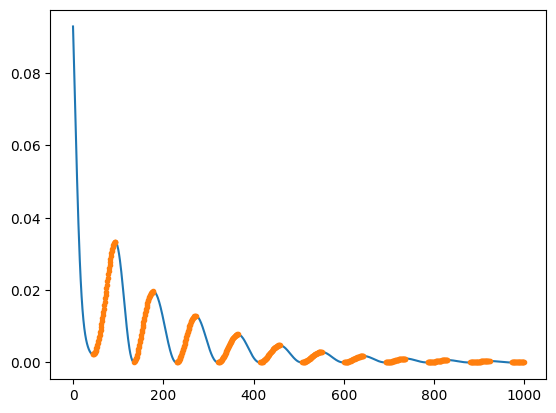

In [44]:
energy, violations = getEnergyViolations(selected_data)
plt.plot(range(len(energy)), energy)
plt.plot(violations, [energy[v] for v in violations], '.')

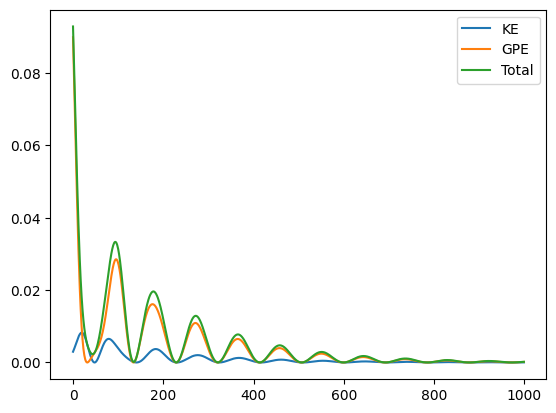

In [45]:
energy = pendulum_energy.pendulum_energy(N)
ke_func = pendulum_energy.pendulum_energy(N, include_gpe=False, include_ke=True)
gpe_func = pendulum_energy.pendulum_energy(N, include_gpe=True, include_ke=False)
energy     = energy_func(torch.tensor(selected_data)).numpy()
energy_ke  =     ke_func(torch.tensor(selected_data)).numpy()
energy_gpe =    gpe_func(torch.tensor(selected_data)).numpy()
plt.plot(range(len(energy_ke)), energy_ke)
plt.plot(range(len(energy_gpe)), energy_gpe)

violations = []
p_e = 999999
for i, e in enumerate(energy):
    if p_e < e:
        violations.append(i)
    p_e = e

plt.plot(range(len(energy)), energy)
# plt.plot(violations, [energy[v] for v in violations], '.')
plt.legend(["KE", "GPE", "Total"])

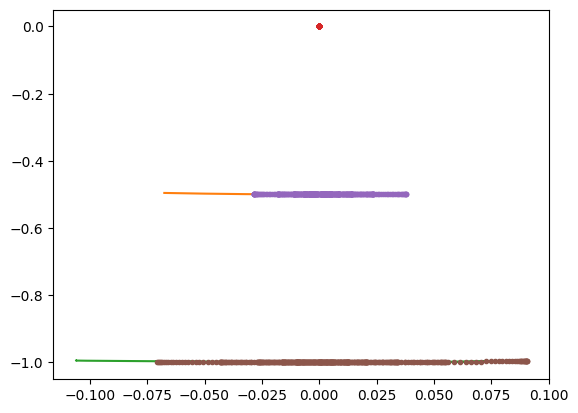

In [46]:
x, y = get_xy_coords(selected_data)
plt.plot(x, y);

v_coords = [coords for i, coords in enumerate(zip(x, y)) if i in violations]
plt.plot(*zip(*v_coords), '.')
None

## Pendulum Animations

The static plots above provide a bit of insight into the situation, but it's much more intuitive to see the results as an animation.
Drawing from the double pendulum code in my [Animation Tutorial](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/), here is a function to animate the pendulum's motion over time:

In [132]:
from matplotlib import animation


def animate_pendulum(selected_data, energy=None, violations=None, fps=60, title=None, true_traj=None):
    x, y = get_xy_coords(selected_data)
    if true_traj is not None:
        x_true, y_true = get_xy_coords(true_traj)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    if true_traj is not None:
        true, = ax.plot([], [], 'o-', lw=2)
    line, = ax.plot([], [], 'o-', lw=2)
    if title is not None:
        title_box = ax.text(0.5,0.9, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5}, transform=ax.transAxes, ha="center")
    energy_box = ax.text(0.5,0.5, "", bbox={'facecolor':'k', 'alpha':0.5, 'pad':5}, transform=ax.transAxes, ha="center")
    time_box = ax.text(0.1,0.9, "", bbox={'facecolor':'k', 'alpha':0.5, 'pad':5}, transform=ax.transAxes, ha="center")
    
    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        # Adding time, title and a plot of the true trajectory behind the predicted trajectory
        time_box.set_text(f"Time {i}")
        if title is not None:
            title_box.set_text(title)
        if true_traj is not None:
            true.set_data(x_true[i], y_true[i])
            true.set_color('gray')

        # If selected_Data[i] is a 0 array, then don't plot it
        if all(selected_data[i] == 0):
            return line, energy_box
        if energy is not None:
            pass
            energy_box.set_text(f"Energy {energy[i]}")
        line.set_data(x[i], y[i])
        if violations is not None and i in violations:
            line.set_color('r')
        else:
            line.set_color('b')
        
        
            
        return line, energy_box

    anim = animation.FuncAnimation(fig, animate, frames=x.shape[0],
                                   interval=1/fps*1000,
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

anim = animate_pendulum(selected_data, energy, violations)

In [117]:

HTML(anim.to_html5_video())  # uncomment to embed
# Save to file
# anim.save('animation.mp4', fps=30)

In [141]:
def loadData(filepath):

    def scaleAngErr(ang_error):
        # Scales errors to the range [0, 2pi)
        mod = ang_error//(2*np.pi)
        ang_error -= mod*2*np.pi
        # assert all([np.all(ang_error <= 2*np.pi), np.all(ang_error >= 0)]), f"Angles not in range [0, 2pi]: {ang_error[ang_error > 2*np.pi], ang_error[ang_error < 0]}"

        # Then moves them to the range (-pi, pi]
        if np.any(ang_error > np.pi):
            ang_error[ang_error > np.pi] -= 2*np.pi
        assert all([np.all(ang_error <= np.pi), np.all(ang_error >= -np.pi)]), f"Angles not in range [-pi, pi]: {ang_error[ang_error > np.pi], ang_error[ang_error < -np.pi]}"

        return ang_error

    n = int(filepath.split("/")[2])

    pred = np.load(filepath)
    true = np.load(f"pendulum-cache/p-physics-{n}.npy")
    print(f"True path: pendulum-cache/p-physics-{n}.npy")

    # vel_error = np.sum((X_phy[i,:,n:] - y[:,n:])**2)
    # ang_error = (X_phy[i,:,:n] - y[:,:n]).astype('float64')
    # ang_error = scaleAngErr(ang_error)

    # ang_error = np.sum(ang_error**2)

    # errors[i] = (vel_error + ang_error)

    vel_error = np.sum((pred[..., n:] - true[..., n:])**2, axis=-1)
    ang_error = (pred[..., :n] - true[..., :n]).astype('float64')
    ang_error = scaleAngErr(ang_error)
    ang_error = np.sum(ang_error**2, axis=-1)

    err = vel_error + ang_error

    return pred, true, err

In [149]:
def plot_errors(errors, chosen_run, chosen_traj, n=None, title = None, ylim=None, xlim=None):
    print(f"Plotting errors for {errors.shape[1]} trajectories")
    if n is not None:
        if n >= errors.shape[0]:
            idx = np.arange(errors.shape[0])
        else:
            # Choose n random indices
            idx = np.random.choice(errors.shape[1], n, replace=False)
        alpha = (0.9*n + 0.1 - errors.shape[1])/(1 - errors.shape[1]) # alpha = 0.1 if n = errors.shape[1], alpha = 1 if n = 1, linear in between
    else:
        idx = np.arange(errors.shape[1])
        alpha = 0.1

    for i in idx:
        plt.plot(errors[chosen_run, :, i], color = 'gray', alpha=alpha, linewidth=0.5)
    plt.plot(errors[chosen_run, :, chosen_traj], color='red', label="Chosen")
    plt.plot(errors[chosen_run].mean(axis=-1), color='blue', label="Mean")
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel("Error")

    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    
    plt.title(  ("Sampled" if n else "All runs") + f", chosen run, and mean errors {f': {title}' if title else '' }" )
    plt.show()

###  Comparing results of predictions and actuals:

In [79]:
chosen_traj = np.random.randint(1000) 
fps=60
chosen_traj

790

#### Predicted behaviour (simple 2-link)

True path: pendulum-cache/p-physics-2.npy
Loaded data: (30, 1000, 1000, 4)
16
Plotting errors for 1000 trajectories


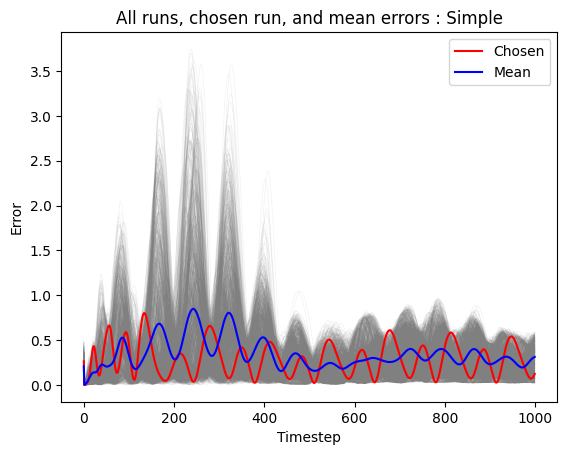

In [151]:
predicted_simp, true, err = loadData("experiments/error_simple/2/3_pred.npy")
print(f"Loaded data: {predicted_simp.shape}")
chosen_run = np.argmin(err.mean(axis=1).mean(axis=-1))
print(chosen_run)

plot_errors(err, chosen_run, chosen_traj, title="Simple")

selected_pred_simp = predicted_simp[chosen_run,:,chosen_traj,:]
selected_true = true[:,chosen_traj,:]
e, v = getEnergyViolations(selected_pred_simp) # violations are times where the total energy in the system increases
anim = animate_pendulum(selected_pred_simp, e, v, fps=fps, title="Simple", true_traj=selected_true)
anim.save("simple_pred.mp4", fps=fps)
HTML(anim.to_html5_video())  # uncomment to embed

#### Predicted behaviour (stable 2-link)

True path: pendulum-cache/p-physics-2.npy
11
Plotting errors for 1000 trajectories
(29, 1000, 1000)


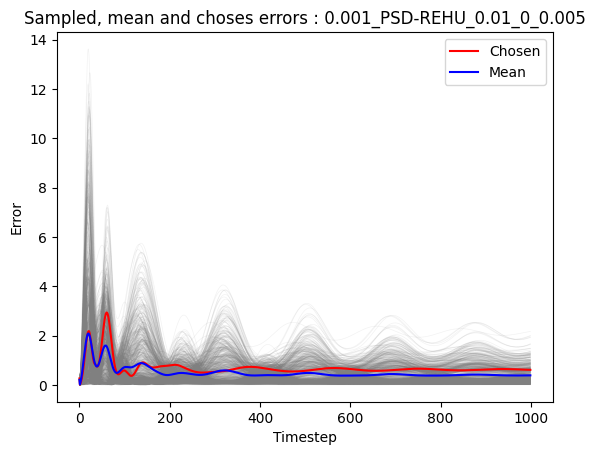

In [140]:
predicted_stab, true, err = loadData(f"experiments/error_stable/2/0.001_PSD-REHU_0.01_0_0.005/2_pred.npy")
chosen_run = np.argmin(err.mean(axis=1).mean(axis=-1))
print(chosen_run)

plot_errors(err, chosen_run, chosen_traj, title="0.001_PSD-REHU_0.01_0_0.005")

selected_pred_stab = predicted_stab[chosen_run,:,chosen_traj,:]
selected_true = true[:,chosen_traj,:]
e, v = getEnergyViolations(selected_pred_stab) # violations are times where the total energy in the system increases
anim = animate_pendulum(selected_pred_stab, e, v, fps=fps, title="0.001_PSD-REHU_0.01_0_0.005", true_traj=selected_true)
anim.save('stable_pred.mp4', fps=fps)
HTML(anim.to_html5_video())  # uncomment to embed

#### Actual behavior (as per p-physics)

In [113]:
physics = np.load(f"pendulum-cache/p-physics-{predicted_simp.shape[-1]//2}.npy")
selected_phy = physics[:,chosen_traj,:]
print(selected_phy.shape)
e, v = getEnergyViolations(selected_phy)
anim = animate_pendulum(selected_phy, e, v, fps=fps, title="Physics")
anim.save('physics_true.mp4', fps=fps)
HTML(anim.to_html5_video())

(1000, 2)


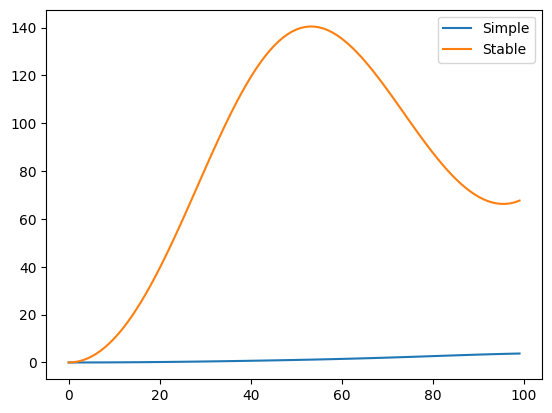

In [ ]:
# errors
errors_simp = np.load(f"experiments/error_simple/1/1.npy").mean(axis=0)
errors_stab = np.load(f"experiments/error_stable/1/0.001_PSD-REHU_0.01_0_0.001/1.npy").mean(axis=0)

plt.plot(errors_simp[:100], label="Simple")
plt.plot(errors_stab[:100], label="Stable")
plt.legend()

In [ ]:
print("mean error simple", errors_simp.mean())
print("mean error stable", errors_stab.mean())

mean error simple 14.237047379465421
mean error stable 92.77340776977941


In [ ]:
import torch

data = torch.load("experiments/pendulum-stable/3_0.001_PSD-REHU_0.005_10_0.001/checkpoint_01000.pth")
data.keys()

odict_keys(['fhat.0.weight', 'fhat.0.bias', 'fhat.2.weight', 'fhat.2.bias', 'fhat.4.weight', 'fhat.4.bias', 'V.zero', 'V.f.W.0', 'V.f.W.1', 'V.f.W.2', 'V.f.U.0', 'V.f.U.1', 'V.f.bias.0', 'V.f.bias.1', 'V.f.bias.2'])